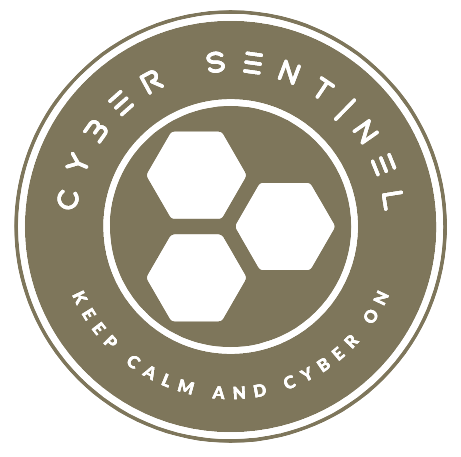

L'ensemble de données UNSW-NB15 est conçu pour servir à la fois à la classification binaire et à la classification multiclasse en matière de détection des intrusions :


>Classification binaire : Dans ce scénario, le modèle prédit si un trafic est normal ou malveillant. C'est le cas le plus courant en détection d'intrusion. Pour cela, la colonne label est utilisée comme cible, où 0 indique un trafic normal et 1 un trafic malveillant.

>Classification multiclasse : Le modèle prédit le type spécifique d'attaque. L'ensemble de données UNSW-NB15 contient plusieurs types d'attaques et permet l'entraînement du modèle en suivant la colonne attack_cat. Dans un souci de gain de temps et surtout de puissance de GPU, nous n'obterons pas pour cette option.

## **-- PREPARATION --**

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import glob

import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

### Création du dataframe

In [2]:
path = r"E:\CYBERSENTINEL\DB\*.csv"
all_files = glob.glob(path)
dfs = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    dfs.append(df)

all_data = pd.concat(dfs, axis=0, ignore_index=True)

#Ajout des noms de colonnes ! Allons les chercher dans NUSW-NB15_features.csv :
df_col = pd.read_csv(r'E:\CYBERSENTINEL\DB\features\NUSW-NB15_features.csv', encoding='ISO-8859-1')


#Harmonisation des noms de colonnes : minuscules partout, retirer les espaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())


#Renommage des noms de colonnes
all_data.columns = df_col['Name']

#Création d'un dictionnaire vide
saved_dict = {}

#Sauvegarde des infos, utiles ultérieurement pour transformer les données brutes des tests.
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()

#Suppression du data frame n'apportant que le header et le descriptif
del df_col

all_data = all_data.drop(0)

Affichage

In [3]:
all_data.shape

all_data.head()


Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
5,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,NaN,0


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540046 entries, 1 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

Les données contiennent plusieurs colonnes, dont certaines sont des caractéristiques des paquets réseau et d'autres semblent être des métadonnées ou des statistiques dérivées.
Les colonnes comme srcip, dstip, sport, et dsport sont essentielles pour identifier la source et la destination du trafic.
Les colonnes liées à la durée, au débit, à la taille des paquets et aux paquets perdus peuvent fournir des informations sur la qualité et la nature du trafic.
Les colonnes comme state, service, proto et attack_cat peuvent aider à catégoriser le trafic.
Les colonnes comme tcprtt, synack, et ackdat sont importantes pour l'analyse du trafic TCP.
Les colonnes Label et attack_cat sont essentielles pour l'analyse des intrusions et la détection des attaques.

- srcip, dstip: Adresses IP source et destination. Ce sont des informations clés pour identifier d'où proviennent les données et où elles vont.

- sport, dsport: Ports source et destination. Ils sont essentiels pour identifier quel service ou application est utilisé dans une transaction.

- proto: Protocole de transaction. Cette information est utile pour classer le type de trafic.

- state: Indique l'état de la connexion, ce qui peut aider à identifier des comportements anormaux.

- dur: Durée de la connexion. Les connexions très courtes ou très longues peuvent être suspectes.

- sbytes, dbytes: Quantité de données envoyées et reçues. Une grande quantité de données peut indiquer un transfert de données important, comme un téléchargement.

- sttl, dttl: Time to Live des paquets. Des valeurs anormales peuvent indiquer des tentatives de masquage de trafic.

- sloss, dloss: Paquets perdus. Une grande perte de paquets peut indiquer un réseau de mauvaise qualité ou des attaques.

- service: Type de service utilisé. Certains services sont plus souvent ciblés par des attaques.

- Sload, Dload: Débit du réseau. Un débit anormalement élevé ou faible peut être suspect.

- Spkts, Dpkts: Nombre de paquets envoyés et reçus.

- swin, dwin: Valeurs de la fenêtre TCP. Des valeurs anormales peuvent indiquer des tentatives d'attaque.

- stcpb, dtcpb: Numéros de séquence TCP. Ils sont importants pour l'analyse du trafic TCP.

- smeansz, dmeansz: Taille moyenne des paquets.

- trans_depth: Profondeur de la transaction HTTP.

- res_bdy_len: Taille du contenu HTTP.

- Sjit, Djit: Jitter source et destination. Le jitter peut indiquer des problèmes de réseau.

- Stime, Ltime: Temps de début et de fin de l'enregistrement.

- Sintpkt, Dintpkt: Temps entre paquets.

- tcprtt, synack, ackdat: Temps de configuration de la connexion TCP.

- is_sm_ips_ports: Indique si l'adresse IP source et destination ainsi que les ports sont identiques.

- ct_state_ttl, ct_flw_http_mthd, is_ftp_login, ct_ftp_cmd, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm: Ces colonnes fournissent des informations sur le comportement et les motifs des connexions.

- attack_cat: Catégorie d'attaque. C'est une information essentielle pour classer et identifier le type d'attaque.

- Label: Étiquette indiquant si c'est une attaque ou non.

## **-- NETTOYAGE --**

J'instaurerai plus tard que prévu train et test. Mais je renomme le DF pour ne pas modifier chaque ligne de code écrit précédemment !

In [4]:
train = all_data


1.   Vérifier s'il y a des valeurs manquantes.
2.   Vérifier la présence de valeurs aberrantes ou suspectes.
3.   Examiner la distribution des types de données.
4.   Examiner les valeurs uniques pour les colonnes catégorielles et convertir les caractéristiques catégorielles en numériques (par exemple, "proto", "state").
5.   Normaliser les caractéristiques numériques.




### Données redondantes

In [5]:
doublons = train.duplicated()

# Afficher les lignes en double
print(train[doublons])

# Compter le nombre total de lignes en double
nb_doublons = train.duplicated().sum()
print(f"Nombre total de lignes en double : {nb_doublons}")

Name              srcip  sport          dstip dsport proto state        dur  \
11          10.40.170.2      0    10.40.170.2      0   arp   INT   0.000000   
12          10.40.182.3      0    10.40.182.3      0   arp   INT   0.000000   
72           59.166.0.6  15807  149.171.126.7     53   udp   CON   0.001118   
121         10.40.182.1      0      224.0.0.5      0  ospf   INT  50.004337   
122          10.40.85.1      0      224.0.0.5      0  ospf   INT  50.004341   
...                 ...    ...            ...    ...   ...   ...        ...   
2540042  149.171.126.18   1043   175.45.176.3     53   udp   INT   0.000005   
2540043  149.171.126.18   1043   175.45.176.3     53   udp   INT   0.000005   
2540044  149.171.126.18   1043   175.45.176.3     53   udp   INT   0.000005   
2540045  149.171.126.18   1043   175.45.176.3     53   udp   INT   0.000005   
2540046      59.166.0.1  18247  149.171.126.4   7662   tcp   FIN   0.119596   

Name     sbytes  dbytes  sttl  ...  ct_ftp_cmd  ct_

In [6]:
# Identifiez les indices des lignes en double
index_doublons = train.duplicated().index[train.duplicated()].tolist()

# Obtenez les valeurs UNIQUE de la colonne 'label' pour ces indices
valeurs_label_doublons = train.loc[index_doublons, 'label'].unique()

# Affichez les valeurs de la colonne 'label' des lignes redondantes
print(valeurs_label_doublons)

[0 1]


In [7]:
# Filtrer les lignes doublons dont label=0
doublons_label_0 = train.duplicated() & (train['label'] == 0)

# Compter ces lignes
nb_doublons_label_0 = doublons_label_0.sum()
print(f"Nombre de lignes doublons dont label=0 : {nb_doublons_label_0}")

# Supprimer ces lignes du DataFrame
train = train[~doublons_label_0] # ~ est l'opérateur de négation

Nombre de lignes doublons dont label=0 : 258992


### Valeurs nulles, manquantes

In [8]:
#Vérification des valeurs nulles
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

Les "Pas d'attaque" (NaN) sont renommées en "normal" et on retire le "s" qui apparaît après certains "backdoors".

In [9]:
train['attack_cat'].value_counts()

attack_cat
Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: count, dtype: int64

In [10]:
train['attack_cat'] = train.attack_cat.fillna(value="normal")
train['attack_cat'] = train['attack_cat'].astype(str).apply(lambda x: x.strip().lower())
train['attack_cat'] = train.attack_cat.replace("backdoors", "backdoor")
train['attack_cat'].value_counts()

attack_cat
normal            1959771
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: count, dtype: int64

Remplissage de valeurs nulles (NaN) dans les colonnes "ct_flw_http_mthd" et "is_ftp_login" par "0"

In [11]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)

train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)

In [11]:
#Résultat ?
train.isnull().sum().sum()

0

### Valeurs aberrantes ou suspectes

In [12]:
# Display descriptive statistics for numerical columns
numerical_stats = train.describe()

numerical_stats

Name,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,...,ct_flw_http_mthd,is_ftp_login,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,label
count,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,...,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06,2.281054e+06
mean,6.323780e-01,4.653846e+03,3.787780e+04,6.378117e+01,3.341327e+01,5.534114e+00,1.710738e+01,1.821878e+07,2.667304e+06,3.518462e+01,...,1.090886e-01,1.791847e-02,7.374408e+00,7.149036e+00,5.052142e+00,5.543580e+00,3.181389e+00,2.455944e+00,4.879971e+00,1.408485e-01
std,1.058703e+01,5.948336e+04,1.620631e+05,7.836606e+01,4.386013e+01,2.357392e+01,5.691105e+01,8.224749e+07,4.346073e+06,7.742395e+01,...,5.058813e-01,1.346886e-01,8.760430e+00,8.711259e+00,6.303884e+00,6.437609e+00,6.445373e+00,4.617097e+00,8.863460e+00,3.478653e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.089000e-03,1.460000e+02,1.780000e+02,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00,1.048270e+05,5.477719e+04,2.000000e+00,...,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.989800e-02,1.580000e+03,2.410000e+03,3.100000e+01,2.900000e+01,3.000000e+00,4.000000e+00,5.615826e+05,6.384050e+05,1.400000e+01,...,0.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00
75%,2.437620e-01,3.406000e+03,1.586800e+04,3.100000e+01,2.900000e+01,7.000000e+00,1.500000e+01,1.608265e+06,3.489378e+06,4.600000e+01,...,0.000000e+00,0.000000e+00,9.000000e+00,8.000000e+00,5.000000e+00,6.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00
max,8.786638e+03,1.435577e+07,1.465753e+07,2.550000e+02,2.540000e+02,5.319000e+03,5.507000e+03,5.988000e+09,1.287619e+08,1.064600e+04,...,3.600000e+01,4.000000e+00,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.000000e+01,6.700000e+01,1.000000e+00


Les statistiques descriptives nous fournissent des informations utiles sur la distribution des données pour chaque colonne numérique. Voici quelques points à noter:

Certaines colonnes ont des valeurs minimales ou maximales qui peuvent être considérées comme extrêmes par rapport à la distribution générale. Par exemple, pour la colonne dbytes, le maximum est beaucoup plus élevé que le 75e percentile.
Certaines colonnes ont une distribution très concentrée autour de valeurs spécifiques. Par exemple, les colonnes sttl, dttl, et plusieurs autres ont une médiane et un mode qui sont les mêmes ou très proches.

## Conversion en Parquet
Suite aux rapports d'erreur lors de création de .parquet

In [12]:
non_numeric_values = train['sport'][~train['sport'].astype(str).str.isnumeric()].unique()
print(non_numeric_values)

['0x000b' '0x000c' '-']


In [13]:
# Convert the problematic values in 'sport' column to int64
def convert_to_int64_v2(value):
    # Check if the value is already an integer
    if isinstance(value, int):
        return value
    # Convert hexadecimal values to int
    elif value.startswith('0x'):
        return int(value, 16)
    # Convert '-' to a default value (e.g., -1)
    elif value == '-':
        return -1
    # Convert other string values directly to int
    else:
        return int(value)

train['sport'] = train['sport'].apply(convert_to_int64_v2)

# Check the data type and unique non-numeric values again
data_type_sport = train['sport'].dtype
unique_values_sport = train['sport'].unique()

data_type_sport, unique_values_sport

(dtype('int64'),
 array([33661,  1464,  3593, ...,    74,   351,   190], dtype=int64))

In [14]:
# Check unique values in the 'dsport' column to identify problematic values
unique_values_dsport = train['dsport'].unique()

unique_values_dsport

array(['1024', '53', '111', ..., '39200', '62253', '27241'], dtype=object)

In [15]:
def convert_dsport_to_int_updated(value):
    # Check if the value is already an integer or a numeric string
    if isinstance(value, int) or str(value).isnumeric():
        return int(value)
    # Convert hexadecimal values to int
    elif value.startswith('0x'):
        return int(value, 16)
    # Convert '-' to a default value (e.g., -1)
    elif value == '-':
        return -1
    # Convert other string values directly to int (this might not be necessary, but is kept for completeness)
    else:
        return int(value)

# Apply the updated conversion function to the 'dsport' column
train['dsport'] = train['dsport'].apply(convert_dsport_to_int_updated)

# Check the data type and unique non-numeric values again for 'dsport'
data_type_dsport = train['dsport'].dtype
unique_non_numeric_values_dsport_updated = train['dsport'][~train['dsport'].astype(str).str.isnumeric()].unique()

data_type_dsport, unique_non_numeric_values_dsport_updated

(dtype('int64'), array([-1], dtype=int64))

In [16]:
# Check unique values in the 'ct_ftp_cmd' column
unique_values_ct_ftp_cmd = train['ct_ftp_cmd'].unique()

unique_values_ct_ftp_cmd

array([0, 1, 6, 2, 4, 8, 5, 3, ' ', '1', '4', '2', '0'], dtype=object)

In [17]:
def convert_ct_ftp_cmd_updated(value):
    # Check if the value is already an integer
    if isinstance(value, int):
        return value
    # Convert numeric strings to integers
    elif value.strip().isnumeric():
        return int(value)
    # Convert space to a default value (e.g., -1)
    elif value.strip() == '':
        return -1
    # Handle other values (this might not be necessary, but is kept for completeness)
    else:
        return value

# Apply the updated conversion function to the 'ct_ftp_cmd' column in the sample data
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].apply(convert_ct_ftp_cmd_updated)

# Check the data type and unique values again for 'ct_ftp_cmd'
data_type_ct_ftp_cmd_updated = train['ct_ftp_cmd'].dtype
unique_values_ct_ftp_cmd_updated = train['ct_ftp_cmd'].unique()

data_type_ct_ftp_cmd_updated, unique_values_ct_ftp_cmd_updated

(dtype('int64'), array([ 0,  1,  6,  2,  4,  8,  5,  3, -1], dtype=int64))